In [54]:
import open3d as o3d
import numpy as np
import copy
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.collections as mcoll
from matplotlib.collections import LineCollection


### 0. Cleanup Mesh

In [89]:
def remove_redundant_vertices(mesh):
    # Get the vertices and triangles
    vertices = np.asarray(mesh.vertices)
    triangles = np.asarray(mesh.triangles)
    
    # Identify unique vertex indices used in the triangles
    unique_vertex_indices = np.unique(triangles)
    
    # Create a mapping from old vertex indices to new ones
    old_to_new_indices = {old_idx: new_idx for new_idx, old_idx in enumerate(unique_vertex_indices)}
    
    # Create a new list of vertices that are only the used ones
    new_vertices = vertices[unique_vertex_indices]
    
    # Update triangle indices to the new vertex indices
    new_triangles = np.array([[old_to_new_indices[old_idx] for old_idx in triangle] for triangle in triangles])
    
    # Create a new mesh with the cleaned vertices and updated triangles
    cleaned_mesh = o3d.geometry.TriangleMesh()
    cleaned_mesh.vertices = o3d.utility.Vector3dVector(new_vertices)
    cleaned_mesh.triangles = o3d.utility.Vector3iVector(new_triangles)
    
    # Copy colors, normals, etc. if they exist
    if mesh.has_vertex_colors():
        cleaned_mesh.vertex_colors = o3d.utility.Vector3dVector(np.asarray(mesh.vertex_colors)[unique_vertex_indices])
    if mesh.has_vertex_normals():
        cleaned_mesh.vertex_normals = o3d.utility.Vector3dVector(np.asarray(mesh.vertex_normals)[unique_vertex_indices])
    
    return cleaned_mesh

In [92]:
# Load the mesh
mesh = o3d.io.read_triangle_mesh(r'D:\sunny\Codes\DPS\data_teethseg\origin\001002_origin.ply')
# print(np.array(mesh.vertices).shape)
# print(np.array(mesh.triangles).shape)

# Remove redundant vertices
intraoral_mesh = remove_redundant_vertices(mesh)
# print(np.array(mesh.vertices).shape)
# print(np.array(mesh.triangles).shape)

# Visualize the cleaned mesh
o3d.visualization.draw_geometries([intraoral_mesh])

### 1. Create Circle and Extrude to Cylinders as Projection Screens

In [93]:
# Function to create a circle in the x-z plane
def create_circle(radius, n_points=100):
    theta = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    points = np.vstack((x, np.zeros(n_points), z)).T
    lines = np.column_stack((np.arange(n_points), np.roll(np.arange(n_points), -1)))
    return points, lines

# Function to extrude the circles in the y direction to create cylinders
def extrude_circle(points, extrusion_length_pos, extrusion_length_neg):
    extruded_points = []
    for y in [extrusion_length_neg, extrusion_length_pos]:
        extruded_points.append(points + np.array([0, y, 0]))
    extruded_points = np.vstack(extruded_points)
    
    # Create triangular faces for the extrusion
    n_points = len(points)
    faces = []
    for i in range(n_points):
        next_i = (i + 1) % n_points  # Ensure circular connection
        # Create two triangles for each face of the cylinder
        faces.append([i, next_i, next_i + n_points])
        faces.append([i, next_i + n_points, i + n_points])
    
    return extruded_points, faces

Calculate cylinder parameters based on mesh geometry:

In [94]:

# Calculate the radii
distances = np.linalg.norm(np.asarray(intraoral_mesh.vertices)[:, [0, 2]], axis=1)
outer_radius = np.max(distances)
inner_radius = np.min(distances)
n_points = 100

# Calculate the extrusion length
y_min = np.min(np.asarray(intraoral_mesh.vertices)[:, 1])
y_max = np.max(np.asarray(intraoral_mesh.vertices)[:, 1])
extrusion_length_pos = y_max
extrusion_length_neg = y_min
print(f'Extrusion length: {extrusion_length_pos} (pos), {extrusion_length_neg} (neg)')


Extrusion length: 10.955703023791923 (pos), -0.8517375862118236 (neg)


In [95]:
# Create the circles
circle_outer_points, circle_outer_lines = create_circle(outer_radius, n_points)
circle_inner_points, circle_inner_lines = create_circle(inner_radius, n_points)

# Extrude the circles to create cylinders
cylinder_outer_points, cylinder_outer_faces = extrude_circle(circle_outer_points, extrusion_length_pos, extrusion_length_neg)
cylinder_inner_points, cylinder_inner_faces = extrude_circle(circle_inner_points, extrusion_length_pos, extrusion_length_neg)


Create meshes for visualization:

In [96]:
# Create meshes for the extruded cylinders
cylinder_outer = o3d.geometry.TriangleMesh()
cylinder_outer.vertices = o3d.utility.Vector3dVector(cylinder_outer_points)
cylinder_outer.triangles = o3d.utility.Vector3iVector(cylinder_outer_faces)
cylinder_outer.paint_uniform_color([0.5, 0.5, 1.0])

cylinder_inner = o3d.geometry.TriangleMesh()
cylinder_inner.vertices = o3d.utility.Vector3dVector(cylinder_inner_points)
cylinder_inner.triangles = o3d.utility.Vector3iVector(cylinder_inner_faces)
cylinder_inner.paint_uniform_color([0.5, 1.0, 0.5])

# Create coordinate axes
coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=10, origin=[0, 0, 0])

# Create grid lines in the xz plane
grid_x = np.linspace(-100, 100, 201)
grid_z = np.linspace(-100, 100, 201)
grid_points = np.array([[x, 0, z] for x in grid_x for z in grid_z])
grid_lines = []
for i, x in enumerate(grid_x):
    grid_lines.append([i * len(grid_z), (i + 1) * len(grid_z) - 1])
for i, z in enumerate(grid_z):
    grid_lines.append([i, len(grid_x) * len(grid_z) - len(grid_x) + i])
grid = o3d.geometry.LineSet(points=o3d.utility.Vector3dVector(grid_points),
                            lines=o3d.utility.Vector2iVector(grid_lines))
grid.paint_uniform_color([0.8, 0.8, 0.8])

# Visualize the splines, curved planes, coordinate axes, and grid
o3d.visualization.draw_geometries([intraoral_mesh, cylinder_outer, cylinder_inner, coordinate_frame, grid])

### 2. Projections

In [101]:
# Calculate vertex normals
intraoral_mesh.compute_vertex_normals()
vertex_normals = np.asarray(intraoral_mesh.vertex_normals)
vertices = np.asarray(intraoral_mesh.vertices)
faces = np.asarray(intraoral_mesh.triangles)
colors = np.asarray(intraoral_mesh.vertex_colors)

# Classify vertices as inward or outward-facing
outward_facing_mask = np.array([np.dot(normal, vertex) > 0 for normal, vertex in zip(vertex_normals, vertices)])
inward_facing_mask = np.array([np.dot(normal, vertex) < 0 for normal, vertex in zip(vertex_normals, vertices)])
# assert np.sum(outward_facing_mask) + np.sum(inward_facing_mask) == len(vertices), 'Some vertices are not classified'


# Extract inward and outward-facing vertices and colors
outward_facing_vertices = vertices[outward_facing_mask]
outward_facing_colors =colors[outward_facing_mask]
inward_facing_vertices = vertices[inward_facing_mask]
inward_facing_colors = colors[inward_facing_mask]

# Extract inward and outward-facing faces
outward_facing_faces = []
inward_facing_faces = []
for face in faces:
    if np.all(outward_facing_mask[face]): # if all vertices of the face are outward facing
        outward_facing_faces.append(face) # add the face to the outward facing faces
    elif np.all(inward_facing_mask[face]): # if all vertices of the face are inward facing
        inward_facing_faces.append(face) # add the face to the inward facing faces


# for each face, convert indices from original to new vertex indices
outward_facing_idx = np.where(outward_facing_mask)[0]
inward_facing_idx = np.where(inward_facing_mask)[0]

# Create a mapping from old indices to new indices
outward_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(outward_facing_idx)}
inward_idx_map = {old_idx: new_idx for new_idx, old_idx in enumerate(inward_facing_idx)}

# Vectorized approach to update face indices
outward_facing_faces = np.vectorize(outward_idx_map.get)(outward_facing_faces)
inward_facing_faces = np.vectorize(inward_idx_map.get)(inward_facing_faces)



In [102]:
# Project vertices onto the respective cylinders
def project_onto_cylinder(vertices, radius):
    projected_vertices = vertices.copy()
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        projected_vertices[i] = [radius * np.cos(theta), y, radius * np.sin(theta)]
    return projected_vertices

In [103]:
projected_outward_vertices = project_onto_cylinder(outward_facing_vertices, outer_radius)
projected_inward_vertices = project_onto_cylinder(inward_facing_vertices, inner_radius)

# Create meshes for the projected vertices
projected_outward_mesh = o3d.geometry.PointCloud()
projected_outward_mesh.points = o3d.utility.Vector3dVector(projected_outward_vertices)
projected_outward_mesh.colors = o3d.utility.Vector3dVector(outward_facing_colors)

projected_inward_mesh = o3d.geometry.PointCloud()
projected_inward_mesh.points = o3d.utility.Vector3dVector(projected_inward_vertices)
projected_inward_mesh.colors = o3d.utility.Vector3dVector(inward_facing_colors)

In [104]:
# Create a new mesh for visualization
new_mesh = copy.deepcopy(intraoral_mesh)
new_vertices = np.asarray(new_mesh.vertices)
new_vertices[outward_facing_mask] = projected_outward_vertices
new_vertices[inward_facing_mask] = projected_inward_vertices
new_mesh.vertices = o3d.utility.Vector3dVector(new_vertices)

# Visualize the original mesh, projected meshes, and coordinate axes
o3d.visualization.draw_geometries([intraoral_mesh, projected_outward_mesh, projected_inward_mesh, coordinate_frame, cylinder_outer, cylinder_inner])

### 3. Visualize with 2D Flattening

In [105]:
# Flatten the projected vertices into 2D planes
def flatten_to_2d(vertices):
    flattened_vertices = []
    for i in range(vertices.shape[0]):
        x, y, z = vertices[i]
        theta = np.arctan2(z, x)
        if theta < -np.pi/2:
            theta += 2 * np.pi
        flattened_vertices.append([theta, y])
    return np.array(flattened_vertices)

# Flatten the projected vertices into 2D planes
uv_outward = flatten_to_2d(projected_outward_vertices)
uv_inward = flatten_to_2d(projected_inward_vertices)

##### Proper visualization with original colors

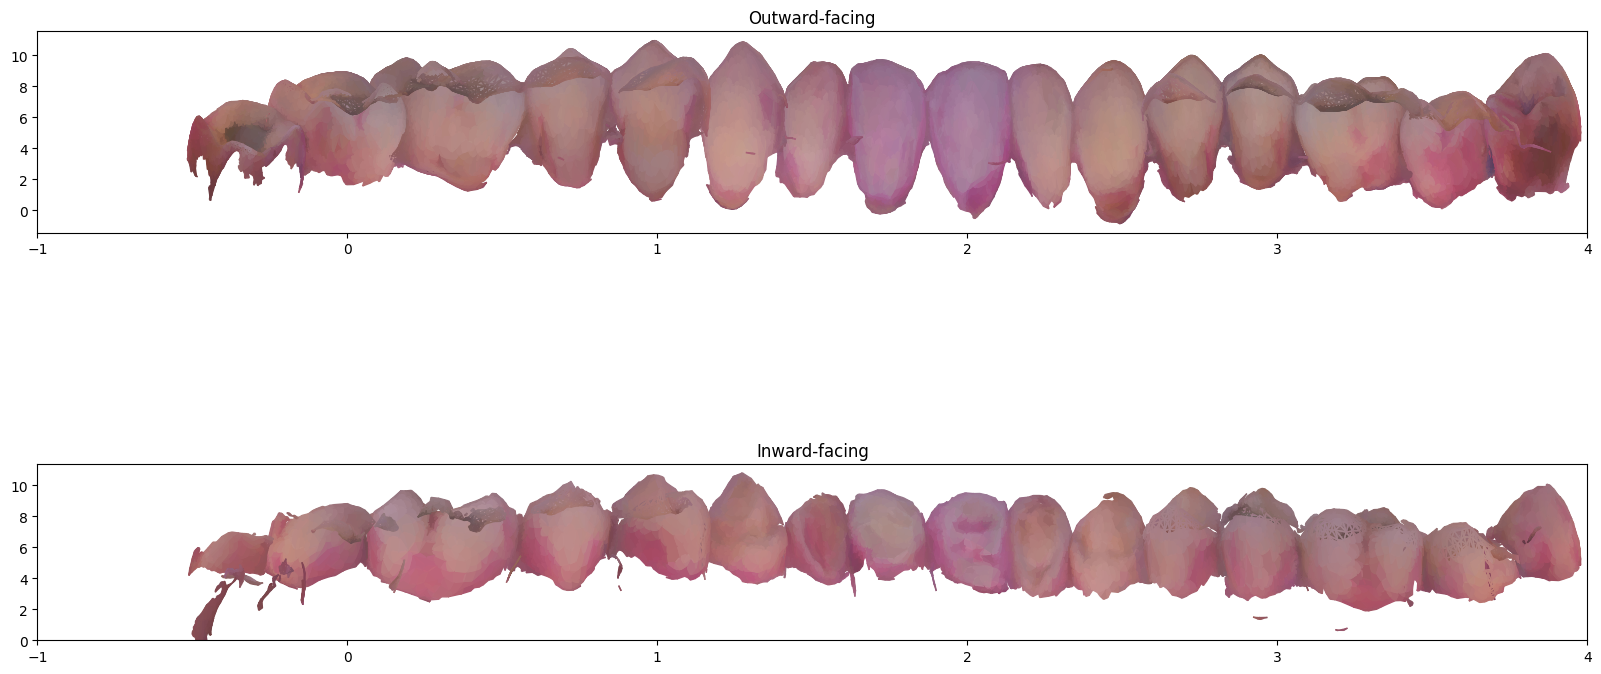

In [106]:
# Function to get the minimum color for each triangle
def get_min_triangle_colors(triangles, colors):
    triangle_colors = []
    for tri in triangles:
        # Extract the colors of the vertices
        color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
        # Get the minimum color value (element-wise)
        min_color = np.minimum(np.minimum(color1, color2), color3)
        triangle_colors.append(min_color)
    return np.array(triangle_colors)

# Function to get the minimum color for each edge
def get_min_edge_colors(triangles, colors):
    edge_colors = []
    edges = []
    for tri in triangles:
        # Extract the colors of the vertices
        color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
        # Define edges as pairs of vertices
        edges.extend([(tri[0], tri[1]), (tri[1], tri[2]), (tri[2], tri[0])])
        # Get the minimum color value (element-wise) for each edge
        edge_colors.append(np.minimum(color1, color2))
        edge_colors.append(np.minimum(color2, color3))
        edge_colors.append(np.minimum(color3, color1))
    return edges, np.array(edge_colors)

"""##################################################### Extract face colors ########################################################"""
# Get the minimum colors for each triangle
outward_triangle_colors = get_min_triangle_colors(outward_facing_faces, outward_facing_colors)
inward_triangle_colors = get_min_triangle_colors(inward_facing_faces, inward_facing_colors)

# Convert triangle vertices to a list of polygons
outward_polygons = [[uv_outward[v[0]], uv_outward[v[1]], uv_outward[v[2]]] for v in outward_facing_faces]
inward_polygons = [[uv_inward[v[0]], uv_inward[v[1]], uv_inward[v[2]]] for v in inward_facing_faces]

# Create PolyCollections
outward_collection = mcoll.PolyCollection(outward_polygons, facecolors=outward_triangle_colors, edgecolors='none', linewidths=0)
inward_collection = mcoll.PolyCollection(inward_polygons, facecolors=inward_triangle_colors, edgecolors='none', linewidths=0)

"""##################################################### Extract edge colors ########################################################"""
# Get the edge colors and edges
outward_edges, outward_edge_colors = get_min_edge_colors(outward_facing_faces, outward_facing_colors)
inward_edges, inward_edge_colors = get_min_edge_colors(inward_facing_faces, inward_facing_colors)

# Create line segments for the edges
outward_segments = [[uv_outward[v1], uv_outward[v2]] for v1, v2 in outward_edges]
inward_segments = [[uv_inward[v1], uv_inward[v2]] for v1, v2 in inward_edges]

# Create LineCollections
outward_lines = LineCollection(outward_segments, colors=outward_edge_colors, linewidths=1)
inward_lines = LineCollection(inward_segments, colors=inward_edge_colors, linewidths=1)


"""########################################## Plot the triangulated mesh with colored faces and edges ###########################################"""
# Plot the triangulated mesh with colored faces
fig, ax = plt.subplots(2, 1, figsize=(20, 10))

# Plot outward-facing vertices
ax[0].add_collection(outward_collection)
ax[0].add_collection(outward_lines)
ax[0].autoscale_view()
ax[0].set_aspect('equal', adjustable='box')
ax[0].set_xlim([-1, 4])
ax[0].set_title('Outward-facing')
ax[0].set_aspect(aspect=0.05)

# Plot inward-facing vertices
ax[1].add_collection(inward_collection)
ax[1].add_collection(inward_lines)
ax[1].autoscale_view()
ax[1].set_aspect('equal', adjustable='box')
ax[1].set_xlim([-1, 4])
ax[1].set_ylim([0, None])
ax[1].set_title('Inward-facing')
ax[1].set_aspect(aspect=0.05)

plt.show()


##### Visualize vertices directly

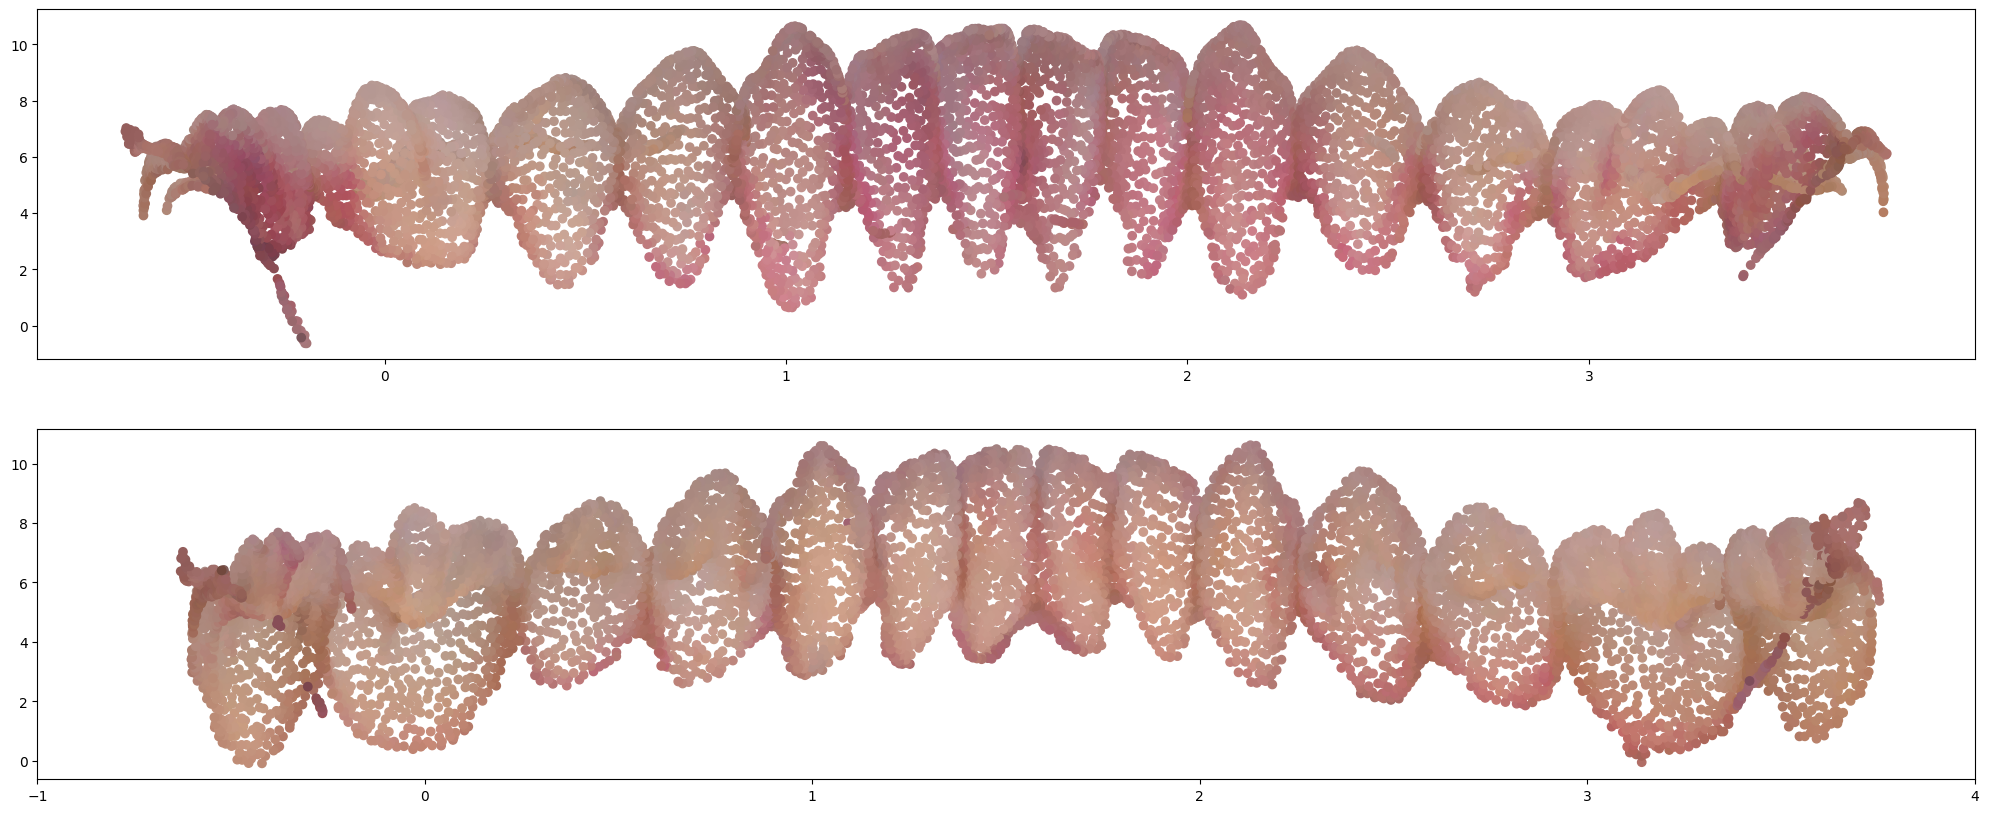

In [71]:
# # Visualize the flattened vertices
# fig, ax = plt.subplots(2,1,figsize=(25, 10))
# ax[0].scatter(uv_outward[:, 0], uv_outward[:, 1], c=outward_facing_colors, label='Outward-facing')
# ax[1].scatter(uv_inward[:, 0], uv_inward[:, 1], c=inward_facing_colors, label='Inward-facing')
# plt.xlim(-1,4)
# plt.show()


##### Visualize in terms of single-channel luminance

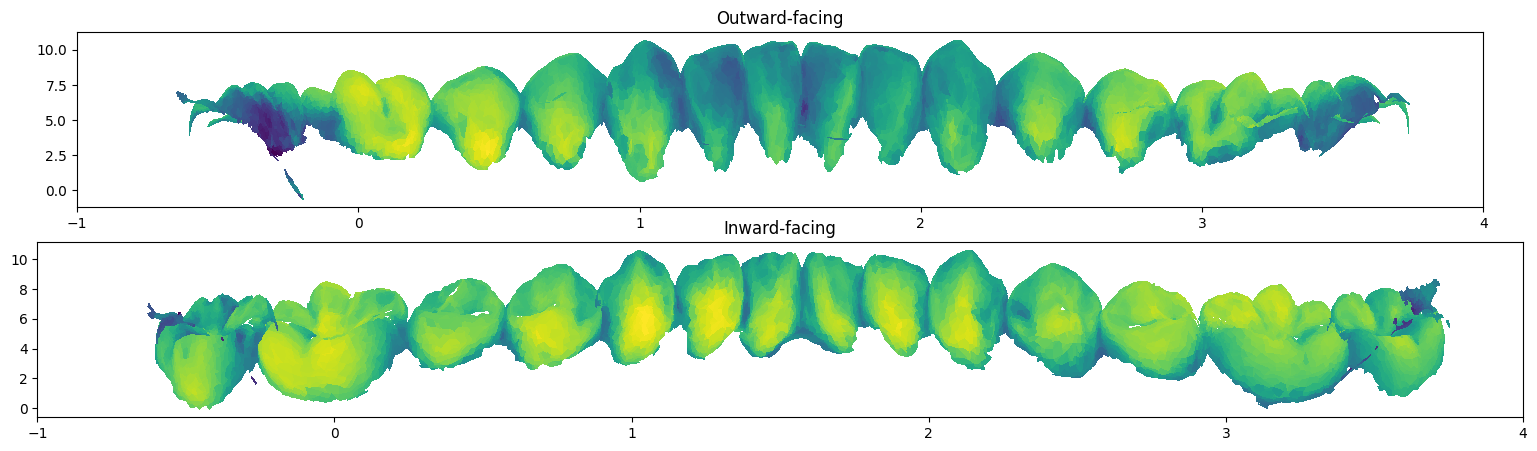

In [38]:
# # Function to get the minimum color for each triangle
# def get_min_triangle_colors(triangles, colors):
#     triangle_colors = []
#     for tri in triangles:
#         # Extract the colors of the vertices
#         color1, color2, color3 = colors[tri[0]], colors[tri[1]], colors[tri[2]]
#         # Get the minimum color value (element-wise)
#         min_color = np.minimum(np.minimum(color1, color2), color3)
#         triangle_colors.append(min_color)
#     return np.array(triangle_colors)

# # Get the minimum colors for each triangle
# outward_triangle_colors = get_min_triangle_colors(outward_facing_faces, outward_facing_colors)
# inward_triangle_colors = get_min_triangle_colors(inward_facing_faces, inward_facing_colors)

# # Convert RGB colors to a single value (e.g., using luminance formula)
# def rgb_to_luminance(colors):
#     return 0.2126 * colors[:, 0] + 0.7152 * colors[:, 1] + 0.0722 * colors[:, 2]

# outward_triangle_luminance = rgb_to_luminance(outward_triangle_colors)
# inward_triangle_luminance = rgb_to_luminance(inward_triangle_colors)

# # Create a triangulation object
# outward_triang = mtri.Triangulation(uv_outward[:, 0], uv_outward[:, 1], outward_facing_faces)
# inward_triang = mtri.Triangulation(uv_inward[:, 0], uv_inward[:, 1], inward_facing_faces)

# # Plot the triangulated mesh with colored faces
# fig, ax = plt.subplots(2, 1, figsize=(20,5))
# ax[0].tripcolor(outward_triang, facecolors=outward_triangle_luminance, edgecolors='none')
# ax[0].set_aspect('equal', adjustable='box')
# ax[0].set_xlim([-1, 4])
# ax[0].set_title('Outward-facing')

# ax[1].tripcolor(inward_triang, facecolors=inward_triangle_luminance, edgecolors='none')
# ax[1].set_aspect('equal', adjustable='box')
# ax[1].set_xlim([-1, 4])
# ax[1].set_title('Inward-facing')
# ax[0].set_aspect(aspect=0.05)
# ax[1].set_aspect(aspect=0.05)
